In [1]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable

In [2]:
%run Accuracy_Module.py
%run DataLoading.py
%run load_and_organize_dataset.py

In [ ]:
!apt-get install p7zip-full
!p7zip -d UTKFace.tar.gz
!tar -xvf UTKFace.tar.gz

In [ ]:
in_path = 'UTKFace/'
out_path = 'Data/'

count = organize_files(in_path, out_path, 1, 95)

In [3]:
num_classes = 95 # Make 1 for regression, 95 for classification

VGG_classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(4096, 4096),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(4096, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(1024, num_classes),
#     nn.Softmax(dim=1)
)

In [4]:
vgg16 = models.vgg16(pretrained=False)
vgg16.classifier = VGG_classifier

In [5]:
# Replace feature weights with those from vgg_face and update state_dict key names
pre_trained = torch.load("vgg_face_dag.pth")
new = list(pre_trained.items())
state_dict = vgg16.state_dict()

count = 0
for key, value in state_dict.items():
    if(key.split('.')[0] == "features"):
        layer_name, weights = new[count]      
        state_dict[key] = weights
        count += 1

vgg16.load_state_dict(state_dict)
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
def evaluate(net, data_loader, criterion):
    total_epoch = 0
    total_loss = 0.0
    
    for inputs, labels in data_loader:
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.long().cuda())
        total_loss += loss.item()
        total_epoch += len(labels)
        
    return total_loss/total_epoch

In [69]:
def predict(model_outputs):
    pred = []
    smax = nn.Softmax(dim=1)
    prob = smax(model_outputs)
    
    for i in range(prob.shape[0]):
        temp = torch.Tensor([(v+1)*k if k > 1e-6 else 0 for v,k in enumerate(prob[i])])
        temp = temp.sum()
        pred.append(temp)
        
    return torch.Tensor(pred)

In [70]:
def get_accuracy(net, data):
    c=0
    mean = 0.0
    for imgs, labels in data:
        mean += labels.sum()
        c+=32
    mean = (mean/c).float()
    
    ss_reg = 0
    ss_total = 0
    
    for imgs, labels in data:
        labels = labels.float() + 1
        output = net(imgs.cuda())
        pred = predict(output)
        
        ss_reg += ((labels - pred)**2).sum()
        ss_total += ((labels - mean)**2).sum()
    
    return 1 - ss_reg/ss_total

In [71]:
def get_off_accuracy(net, data_loader):
    p=0
    freq_pos = np.zeros(81)
    freq_neg = np.zeros(80)
    
    for img, label in data_loader:
        out = net(img.cuda())
        pred = predict(out)
        pred = pred.float()
             
        for i in range(0, len(label)):
            diff = label[i] + 1 - pred[i].long()
            
            if diff >= 0:
                freq_pos[diff] += 1
            else:
                freq_neg[diff] += 1

    freq_total = np.concatenate((freq_neg, freq_pos))
    freq_total = freq_total/freq_total.sum()

    diffs = []
    for n in range(-80, 81):
        diffs.append(n)

    plt.bar(diffs[50:110], freq_total[50:110])
    plt.title("Distribution of Actual-Prediction")
    plt.xlabel("Difference")
    plt.ylabel("Frequency")
    print("+/- 1 years accuracy: {:.2f}%".format(freq_total[79:81].sum()*100))
    print("+/- 5 years accuracy: {:.2f}%".format(freq_total[75:86].sum()*100))
    print("+/- 10 years accuracy: {:.2f}%".format(freq_total[70:91].sum()*100))
    

In [72]:
def train_net(net, batch_size=32, learning_rate=1e-5, num_epochs=5, starting_epoch=0):
    torch.manual_seed(1000)
    
    train_loader, val_loader, test_loader = load_dataset(32)
    
    criterion = nn.CrossEntropyLoss().cuda()          
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    start_time = time.time()
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
    for epoch in range(num_epochs):
        total_epoch = 0
        total_train_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            
            outputs = net(inputs.cuda())
             
            loss = criterion(outputs.cuda(), labels.long().cuda())
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_epoch += len(labels)
            
            if i % 100 == 0:
                print(i)

        train_loss.append(float(total_train_loss)/total_epoch)
        val_loss.append(evaluate(net, val_loader, criterion))
        train_acc.append(get_accuracy(net, train_loader))
        val_acc.append(get_accuracy(net, val_loader))
            
        print("Epoch: {}, Training Loss: {:.3f}, Validation Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Accuracy: {:.3f}"
              .format(epoch+starting_epoch+1, train_loss[-1], val_loss[-1], train_acc[-1], val_acc[-1]))

        model_path = get_model_name("VGG16", batch_size, learning_rate, epoch+starting_epoch+1)
        torch.save(net.state_dict(), model_path)    
        np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
        np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    
    print('Finished Training')
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [73]:
def plot_training_curve(path, num_epochs, starting_epoch = 0):
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    
    epochs = np.arange(1, num_epochs + 1 - starting_epoch)
    
    plt.title("Training vs. Validation Loss")
    plt.plot(epochs, train_loss, label="Train")
    plt.plot(epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training vs Validation Accuracy")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [12]:
train_net(vgg16, batch_size=32, learning_rate=1e-5, num_epochs=10, starting_epoch=4)

0
100
200
300
400
500
Epoch: 5, Training Loss: 0.078, Validation Loss: 0.101, Training Accuracy: 0.914, Validation Accuracy: 0.878
0
100
200
300
400
500
Epoch: 6, Training Loss: 0.068, Validation Loss: 0.102, Training Accuracy: 0.934, Validation Accuracy: 0.883
0
100
200
300
400
500
Epoch: 7, Training Loss: 0.056, Validation Loss: 0.114, Training Accuracy: 0.945, Validation Accuracy: 0.876
0
100
200
300
400
500
Epoch: 8, Training Loss: 0.042, Validation Loss: 0.125, Training Accuracy: 0.955, Validation Accuracy: 0.863
0
100
200
300
400
500
Epoch: 9, Training Loss: 0.041, Validation Loss: 0.137, Training Accuracy: 0.966, Validation Accuracy: 0.865
0
100


KeyboardInterrupt: 

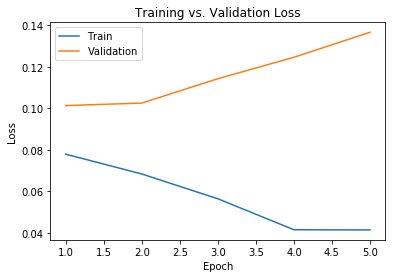

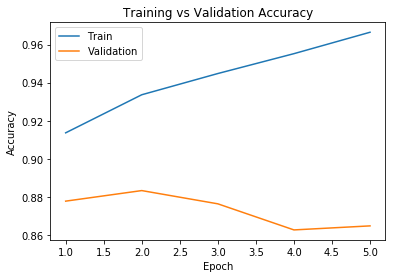

In [14]:
path = get_model_name("VGG16", 32, 1e-5, 9)
plot_training_curve(path, 9, 4)

In [15]:
vgg16.load_state_dict(torch.load(get_model_name("VGG16", 32, 1e-05, 6)))
vgg16.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [16]:
train_loader, val_loader, test_loader = load_dataset(32)

In [74]:
get_accuracy(vgg16, test_loader)

tensor(0.8697)

+/- 1 years accuracy: 23.80%
+/- 5 years accuracy: 71.60%
+/- 10 years accuracy: 89.54%


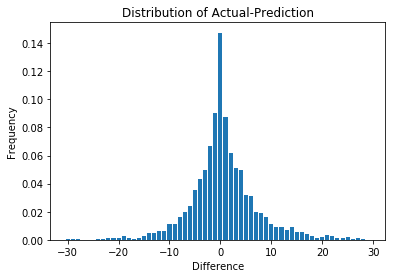

In [75]:
get_off_accuracy(vgg16, test_loader)

+/- 1 years accuracy: 18.51%
+/- 5 years accuracy: 67.74%
+/- 10 years accuracy: 87.35%


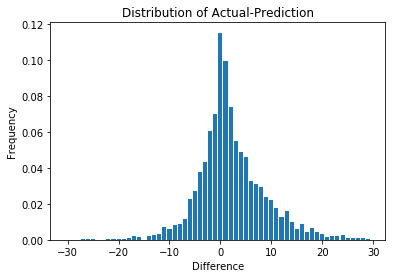

In [54]:
get_off_accuracy(vgg16, val_loader)

+/- 1 years accuracy: 28.11%
+/- 5 years accuracy: 79.46%
+/- 10 years accuracy: 94.34%


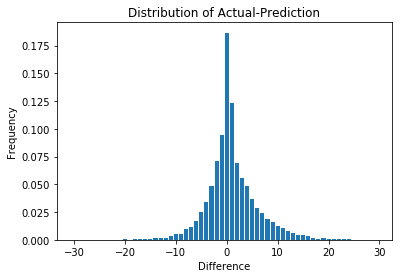

In [45]:
get_off_accuracy(vgg16, train_loader)

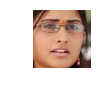

tensor(24) tensor(23.)


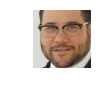

tensor(36) tensor(37.)


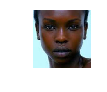

tensor(21) tensor(23.)


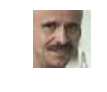

tensor(50) tensor(55.)


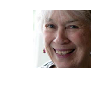

tensor(70) tensor(66.)


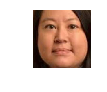

tensor(32) tensor(29.)


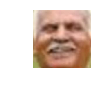

tensor(58) tensor(51.)


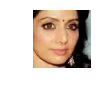

tensor(30) tensor(27.)


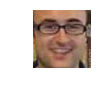

tensor(35) tensor(33.)


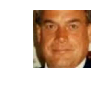

tensor(55) tensor(55.)


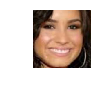

tensor(36) tensor(27.)


In [76]:
k = 0
for image, label in test_loader:
    img = image[0]
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    k += 1
    print(label[0]+1, np.round(predict(vgg16(image.cuda()))[0]))
    if k > 10:
        break